In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
from matplotlib.container import ErrorbarContainer
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection
from matplotlib.ticker import MaxNLocator
import pyodbc
from lmfit.models import PolynomialModel

In [138]:
sql_conn = pyodbc.connect('DRIVER={SQL Server};'
                            'SERVER=L_AAGDATIX;'
                            'DATABASE=DatixCRM;'
                            'Trusted_Connection=yes') 
query = "set transaction isolation level read uncommitted select inc_dincident,inc_dreported from DatixCRM.dbo.incidents_main where inc_type='PAT' and inc_category='MEDIC' and inc_organisation='QA'"
df = pd.read_sql(query, sql_conn)
df.head()

,inc_dincident,inc_dreported
0,2016-03-31,2016-03-31
1,2016-03-31,2016-04-01
2,2016-04-01,2016-04-01
3,2016-03-25,2016-04-01
4,2016-04-02,2016-04-02


In [139]:
df_inc = df.copy()
df_inc = df_inc[df_inc.inc_dincident > '2016-03-31']
df_inc = df_inc[df_inc.inc_dincident < '2019-10-01']
df_inc.head()

,inc_dincident,inc_dreported
2,2016-04-01,2016-04-01
4,2016-04-02,2016-04-02
5,2016-04-01,2016-04-02
6,2016-04-01,2016-04-02
7,2016-04-02,2016-04-02


In [140]:
df_inc['day'] = df_inc['inc_dincident'].dt.day
df_inc.head()

,inc_dincident,inc_dreported,day
2,2016-04-01,2016-04-01,1
4,2016-04-02,2016-04-02,2
5,2016-04-01,2016-04-02,1
6,2016-04-01,2016-04-02,1
7,2016-04-02,2016-04-02,2


In [141]:
bins = [i+0.5 for i in range(32)]
data_x = [i+1 for i in range(31)]
df_grouped_by_day = df_inc.groupby(['inc_dincident']).size().reset_index(name='counts')
df_grouped_by_day[''] = df_grouped_by_day['inc_dincident'].dt.day
df_grouped_by_day.columns = ['inc_dincident','num_on_day','day']
df_grouped_by_day.head()

,inc_dincident,num_on_day,day
0,2016-04-01,4,1
1,2016-04-02,13,2
2,2016-04-03,2,3
3,2016-04-04,4,4
4,2016-04-05,2,5


In [142]:
day_occurences = np.ones(31)*42
day_occurences[-1] = 24
day_occurences[-2] = 39
day_occurences[-3] = 39
print(day_occurences)

[42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42.
 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 39. 39. 24.]


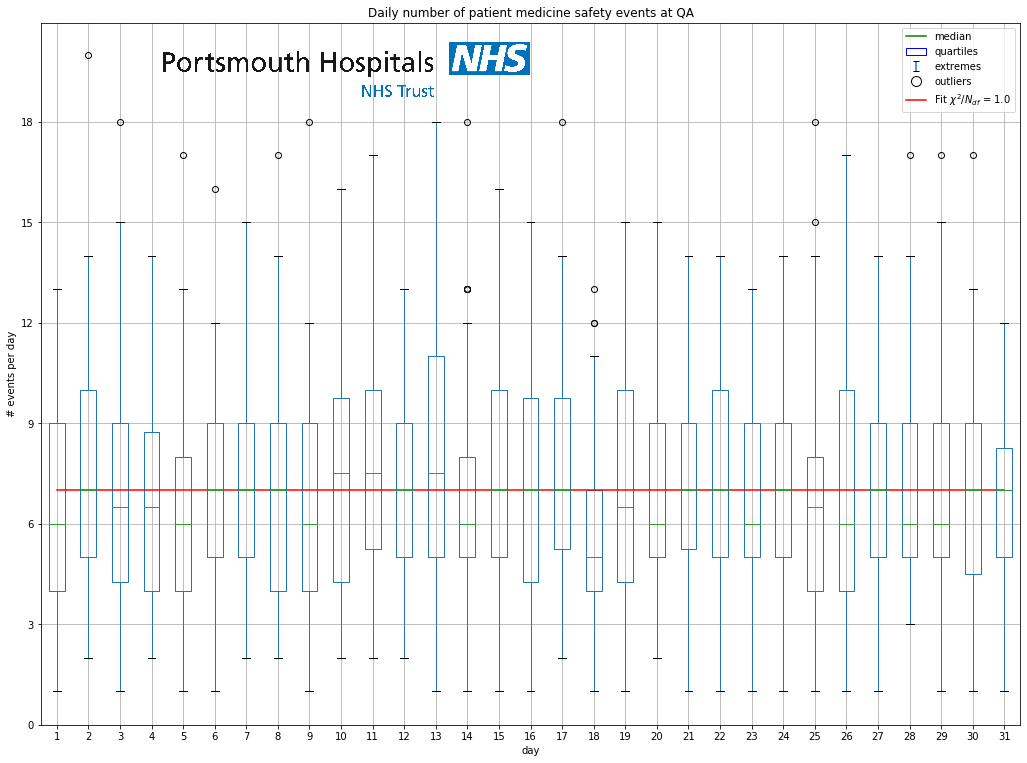

In [143]:
data_y_tot,_ = np.histogram(df_inc.day.values, bins=bins)
data_y = data_y_tot/day_occurences
data_y_err = np.sqrt(data_y_tot)/day_occurences

# data fit
polynomial_mod = PolynomialModel(0)
pars = polynomial_mod.guess(data_y, x=data_x, c0=data_y[0])
model = polynomial_mod
out = model.fit(data_y, pars, x=data_x, weights=1/data_y_err)

df_grouped_by_day.boxplot(by='day',column=['num_on_day'],figsize=(17,13));
plt.plot(data_x, out.best_fit, '-r')
plt.ylim(bottom=0);
plt.ylabel('# events per day');
plt.title('Daily number of patient medicine safety events at QA');
plt.suptitle('');
ax = plt.gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
line = Line2D([],[], ls="none",markeredgecolor='k')
barline = LineCollection(np.empty((2,2,2)))
custom_lines = [Line2D([0], [0], color='green'),
                mpatches.Patch(facecolor='w',edgecolor='b'),
                ErrorbarContainer((line, [line], [barline]), has_yerr=True),
               Line2D([0], [0], marker='o', color='w', markerfacecolor='w', markeredgecolor='k',markersize=10),
               Line2D([0], [0], color='red')]
plt.legend(custom_lines,['median','quartiles','extremes','outliers','Fit '+r'$\chi^2/N_{df}$ = '+str(round(out.redchi))]);
img = plt.imread("nhsportsmouth.png");
ax = plt.axes([0.2,0.7, 0.3, 0.3], frameon=True);  # Change the numbers in this array to position your image [left, bottom, width, height])
ax.imshow(img);
ax.axis('off'); # get rid of the ticks and ticklabels

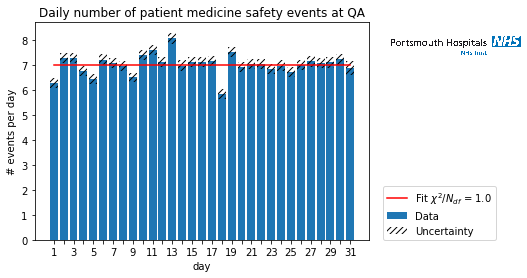

In [144]:
bins = [i+0.5 for i in range(32)]
data_x = [i+1 for i in range(31)]
data_y_tot,_ = np.histogram(df_inc.day.values, bins=bins)
data_y = data_y_tot/day_occurences
data_y_err = np.sqrt(data_y_tot)/day_occurences

k = 0
reduced_chi_sq = 3
while reduced_chi_sq > 2 or reduced_chi_sq < 0.5:
    # data fit
    polynomial_mod = PolynomialModel(k)
    pars = polynomial_mod.guess(data_y, x=data_x, c0=data_y[0])
    model = polynomial_mod
    out = model.fit(data_y, pars, x=data_x, weights=1/data_y_err)

    plt.bar(data_x,data_y,label='Data')
    plt.bar(data_x,data_y_err,bottom=data_y-data_y_err/2,alpha=0.5,color='none',hatch="////",label='Uncertainty')
    plt.plot(data_x, out.best_fit, '-r', label='Fit '+r'$\chi^2/N_{df}$ = '+str(round(out.redchi)))
    plt.legend(loc=(1.04,0))
    ax = plt.gca()
    locs, labels = plt.xticks()
    day_labels = [day if day%2!=0 else '' for day in data_x]
    plt.xticks(data_x,labels=day_labels)
    plt.xlabel('day');
    plt.ylabel('# events per day')
    plt.title('Daily number of patient medicine safety events at QA')
    img = plt.imread("nhsportsmouth.png");
    ax = plt.axes([0.95,0.65, 0.3, 0.3], frameon=True);  # Change the numbers in this array to position your image [left, bottom, width, height])
    ax.imshow(img);
    ax.axis('off'); # get rid of the ticks and ticklabels
    
    reduced_chi_sq = out.redchi
    k+=1

In [146]:
df_rep = df.copy()
df_rep = df_rep[df_rep.inc_dreported > '2016-03-31']
df_rep = df_rep[df_rep.inc_dreported < '2019-10-01']
df_rep.head()

,inc_dincident,inc_dreported
1,2016-03-31,2016-04-01
2,2016-04-01,2016-04-01
3,2016-03-25,2016-04-01
4,2016-04-02,2016-04-02
5,2016-04-01,2016-04-02


In [147]:
df_rep['day'] = df_rep['inc_dincident'].dt.day
df_rep.head()

,inc_dincident,inc_dreported,day
1,2016-03-31,2016-04-01,31
2,2016-04-01,2016-04-01,1
3,2016-03-25,2016-04-01,25
4,2016-04-02,2016-04-02,2
5,2016-04-01,2016-04-02,1


In [148]:
bins = [i+0.5 for i in range(32)]
data_x = [i+1 for i in range(31)]
df_grouped_by_day = df_rep.groupby(['inc_dreported']).size().reset_index(name='counts')
df_grouped_by_day[''] = df_grouped_by_day['inc_dreported'].dt.day
df_grouped_by_day.columns = ['inc_dreported','num_on_day','day']
df_grouped_by_day.head()

,inc_dreported,num_on_day,day
0,2016-04-01,3,1
1,2016-04-02,5,2
2,2016-04-03,2,3
3,2016-04-04,13,4
4,2016-04-05,3,5


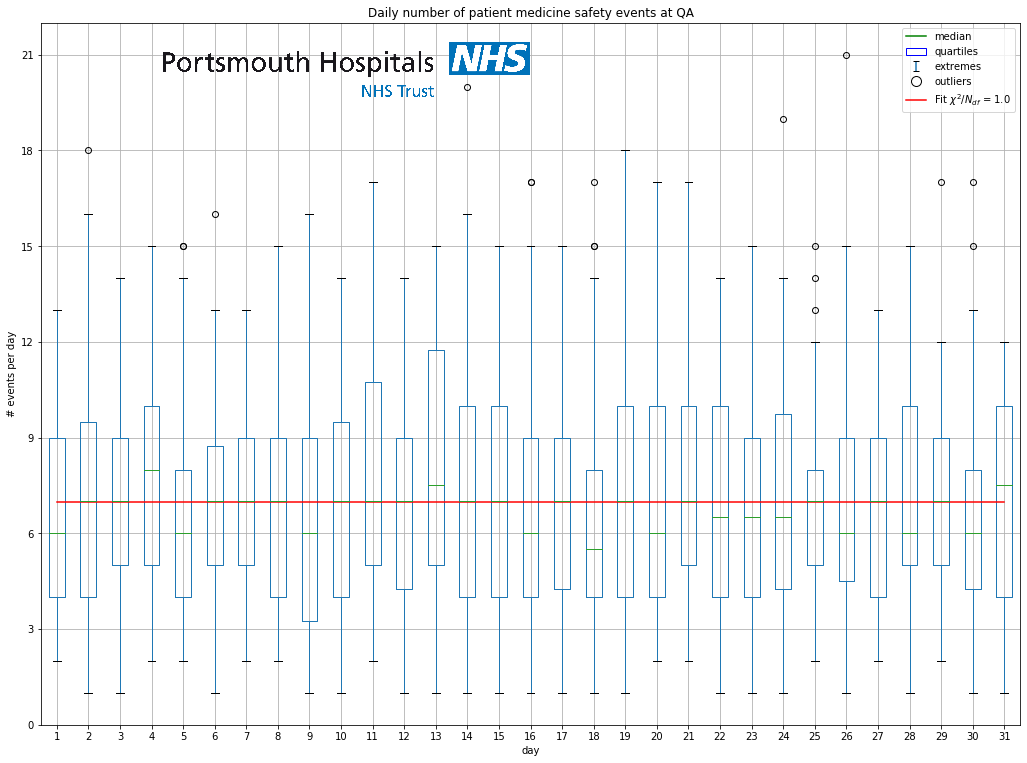

In [149]:
data_y_tot,_ = np.histogram(df_rep.day.values, bins=bins)
data_y = data_y_tot/day_occurences
data_y_err = np.sqrt(data_y_tot)/day_occurences

# data fit
polynomial_mod = PolynomialModel(0)
pars = polynomial_mod.guess(data_y, x=data_x, c0=data_y[0])
model = polynomial_mod
out = model.fit(data_y, pars, x=data_x, weights=1/data_y_err)

df_grouped_by_day.boxplot(by='day',column=['num_on_day'],figsize=(17,13));
plt.plot(data_x, out.best_fit, '-r')
plt.ylim(bottom=0);
plt.ylabel('# events per day');
plt.title('Daily number of patient medicine safety events at QA');
plt.suptitle('');
ax = plt.gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
line = Line2D([],[], ls="none",markeredgecolor='k')
barline = LineCollection(np.empty((2,2,2)))
custom_lines = [Line2D([0], [0], color='green'),
                mpatches.Patch(facecolor='w',edgecolor='b'),
                ErrorbarContainer((line, [line], [barline]), has_yerr=True),
               Line2D([0], [0], marker='o', color='w', markerfacecolor='w', markeredgecolor='k',markersize=10),
               Line2D([0], [0], color='red')]
plt.legend(custom_lines,['median','quartiles','extremes','outliers','Fit '+r'$\chi^2/N_{df}$ = '+str(round(out.redchi))]);
img = plt.imread("nhsportsmouth.png");
ax = plt.axes([0.2,0.7, 0.3, 0.3], frameon=True);  # Change the numbers in this array to position your image [left, bottom, width, height])
ax.imshow(img);
ax.axis('off'); # get rid of the ticks and ticklabels